## Learning outcomes
1. Images histogram : distribution grayscale values
2. Enchance constrast : scalar multiplication on images, histogram equalization and its variant called CLAHE (Contrast Limited Adaptive Histogram Equalization
3. Thresholding : global thresholding at otsu thresholding
4. Morphological operations (limit our discussion on binary image)
5. Color spaces : HSV color space ised to perform color based segmentation

## Setup


In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

### Purpose of Histogram
1. Know the distribution of grayscale values / pixel
2. Use case :
    - Histogram equalization (stretching the histogram, make the graph distribution more evenly, enhance the image contrast)
    - Build image search engine (consider color histogram)

## Image histogram

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# There are 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

36.8 µs ± 239 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.05 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


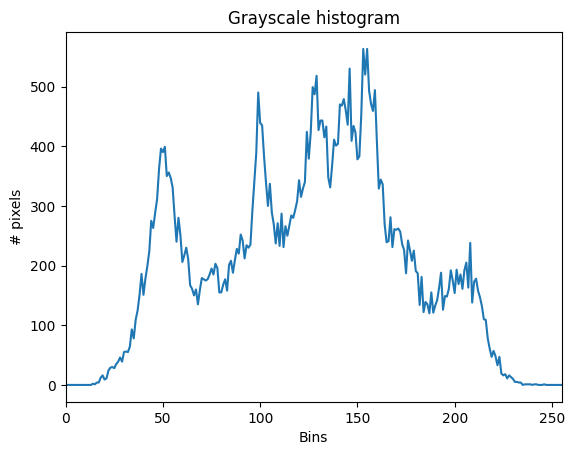

In [4]:
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("Grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

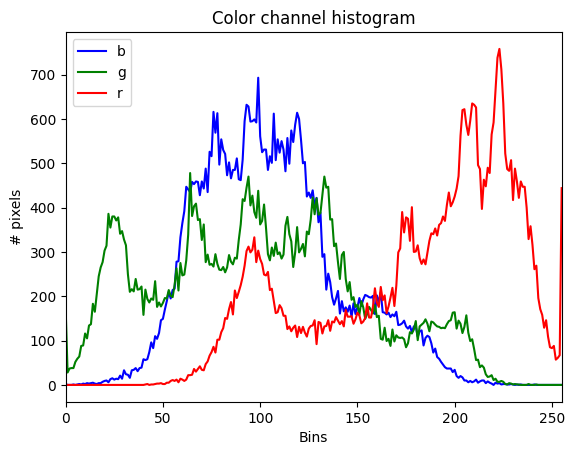

In [5]:
# get the histogram for every channel
channels = cv.split(img)
colors = ("b", "g", "r")

plt.figure()
plt.title("Color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

In [6]:
img = cv.imread("images/low_contrast_img.jfif", 0)
show_img("Low contrast", img)

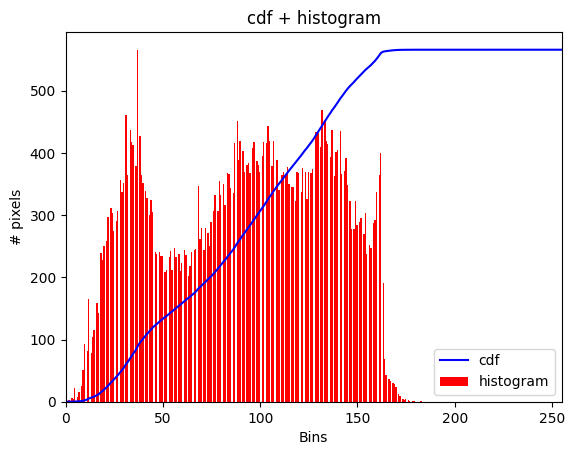

In [7]:
# histogram for this image

hist = cv.calcHist([img], [0], None, [256], [0, 256])

#cdf
cdf = hist.cumsum() # cumulative sum
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(img.flatten(), 256, color="r")

plt.title("cdf + histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0, 255])
plt.show()

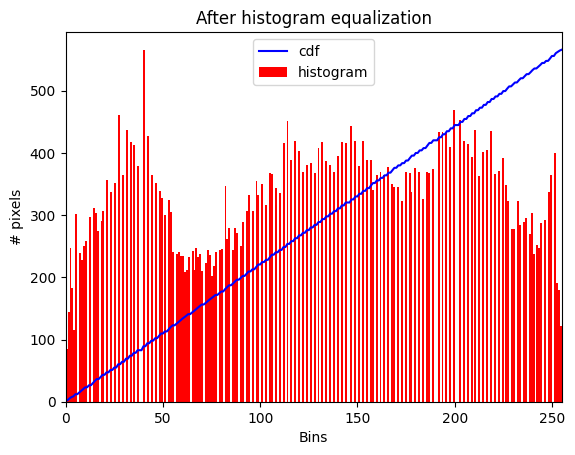

In [8]:
# hisrogram equalization

eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])

#cdf
cdf = hist.cumsum() # cumulative sum
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(eq.flatten(), 256, color="r")

plt.title("After histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0, 255])
plt.show()

## The histogram indicates that the cdf is even

In [9]:
# CLAHE (It divides the histogram into tiles and grids)
# clip limit normally lies on 3-5
# grid size normal lies on 8x8 - 10x10

img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original",img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Exercise 1

In [10]:
img = cv.imread("images/winter.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original",img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Thresholding

In [11]:
## Simple global thresholding
# different types of thresholding

[i for i in dir(cv) if i.startswith("THRES")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [12]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype = np.uint8) # i and j are the pixel coordinates, dont change 256

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Simple global threshold vs Otsu thresholding

It will work best if the histogram is bimodel for otsu thresholding (OTSU selects threshold for us)

In [13]:
img = cv.imread("images/noisy.jfif", 0)
show_img("noisy", img)

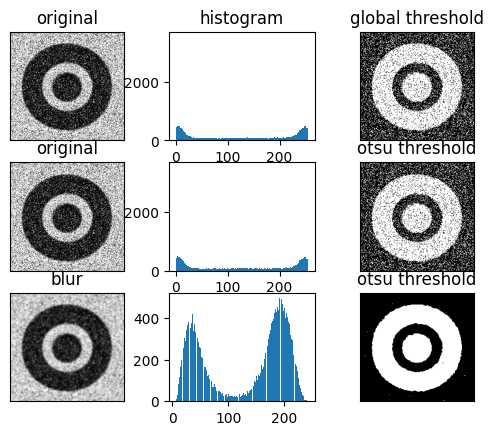

In [14]:
# apply 3 approaches: 1. Global threshold, 2. Otsu threshold, 3. Blurring + otsu

#1:
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3:
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "", "otsu threshold",
         "blur", "", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title = titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Exercise 2

In [15]:
img = cv.imread("images/wood_planck.jfif")
show_img("images",img)



## Morphological transformation
- Erosion (Look at the neighbours of the anchor point, if the neighbours contains at least 1 255 then the point should be 255), expanding white spots
- Dilation (Look at the neighbours of the anchor point, if the neighbours contains at least 1 0 then the point should be 0), expanding black spots
- Opening (Erosion + Dilation) * Remove small white spots (noise) break join
- Closing (Dilation + Erosion) * fill in small hole

In [16]:
# kernel
kernel = np.ones((3,3), np.uint8)

# erosion
erosion = cv.erode(th3, kernel, iterations=1)

# combined
img_combined = np.hstack((th3, erosion))

show_img("erosion", img_combined)

In [17]:
# trackbar: function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while (1):
    # retrieve the size and iteration number
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
    
    kernel = np.ones((size,size), dtype=np.uint8)
    # closing
    closing = cv.morphologyEx(th3, cv.MORPH_OPEN, kernel, iterations=iteration)
    
    cv.imshow(wn, closing)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

In [18]:
cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))

array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

## Color spaces
- RGB/BGR (prevalent image formats)
- HSV (hue, saturation, value)
    * hue encodes color (angular, 0-359). In OpenCV (0-179)
    * saturation implies color purity (the higher the value, the color more pure)
    * value: brightness, 0 is dark (the higher the value, more brighness)
- L\*a\*b:
    * L denotes brightness / luminance while a and b are color channels.
    * perceptual uniformity (setup for mimic human vision)
    

### Sharpen image
1. Change color space
2. Sharpen L channel
3. Merge and convert to BGR

In [19]:
# Sharpen
img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
l, a, b = cv.split(img_lab)

#Process just the L channel and sharpen
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpen = cv.filter2D(l, -1, kernel)

sharpen = cv.merge((l_sharpen, a, b))

# change to bgr
sharpen = cv.cvtColor(sharpen, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", sharpen)

## Demo on color based segmentation

In [20]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

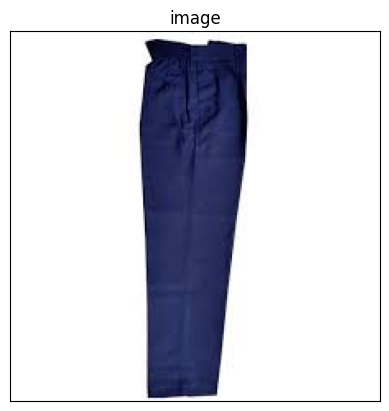

In [21]:
plt_img(img, "image")

In [9]:
## import dependencies
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

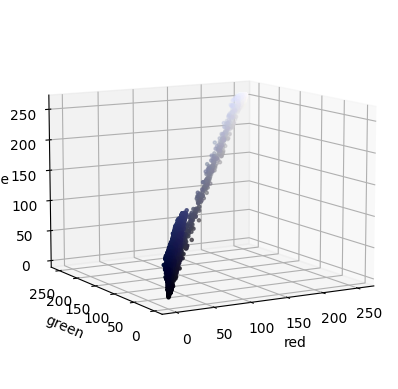

In [23]:
# split the image into seperate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatterplot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")

axis.view_init(elev=10, azim=240)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

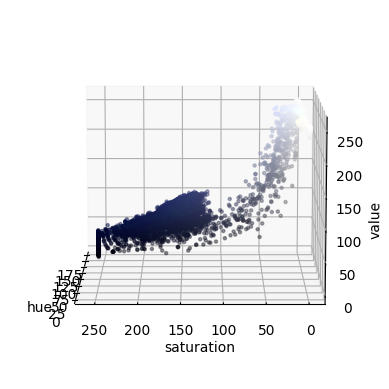

In [24]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")

axis.view_init(elev=10, azim=180)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

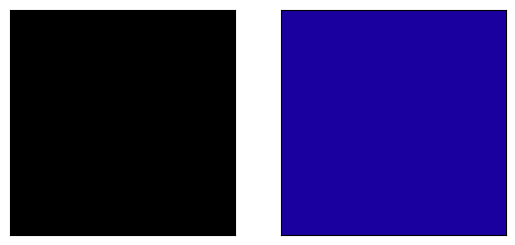

In [25]:
blue_low = (85, 90, 0) #H, S, V
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

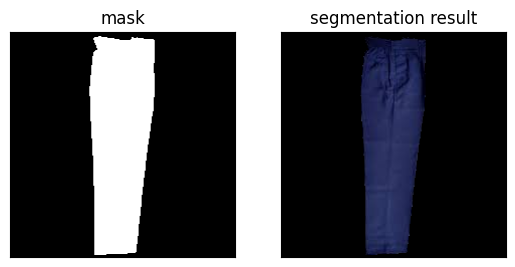

In [26]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)
plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation result")
plt.show()

In [27]:
def color_segmentation(img, color_low, color_high, smooth=True):
    """Args:
    img: source image
    color_low & color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
        
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
res = [color_segmentation(im, blue_low, blue_high) for im in imgs]

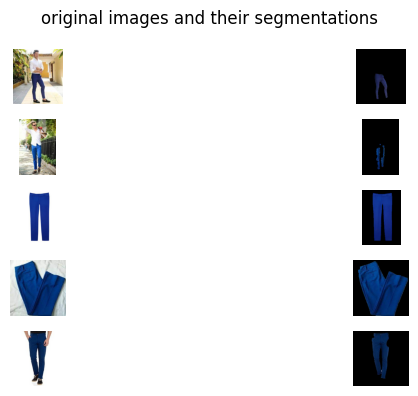

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(10,4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("original images and their segmentations")
plt.tight_layout()
plt.show()

(<Axes: title={'center': 'segmentation result'}>, None)

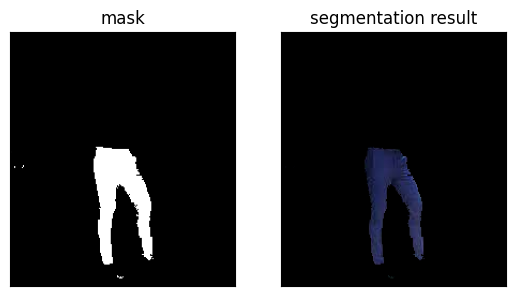

In [29]:
img1 = cv.imread("images/color_space/pant1.jfif")
img2 = cv.imread("images/color_space/pant2.jfif")
img3 = cv.imread("images/color_space/pant3.jfif")
img4 = cv.imread("images/color_space/pant4.jfif")
img5 = cv.imread("images/color_space/pant5.jfif")

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

img1_hsv = cv.cvtColor(img1, cv.COLOR_RGB2HSV)
img2_hsv = cv.cvtColor(img2, cv.COLOR_RGB2HSV)
img3_hsv = cv.cvtColor(img3, cv.COLOR_RGB2HSV)
img4_hsv = cv.cvtColor(img4, cv.COLOR_RGB2HSV)
img5_hsv = cv.cvtColor(img5, cv.COLOR_RGB2HSV)

mask1 = cv.inRange(img1_hsv, blue_low, blue_high)
res1 = cv.bitwise_and(img1, img1, mask=mask1)
mask2 = cv.inRange(img2_hsv, blue_low, blue_high)
res2 = cv.bitwise_and(img2, img2, mask=mask2)
mask3 = cv.inRange(img3_hsv, blue_low, blue_high)
res3 = cv.bitwise_and(img3, img3, mask=mask3)
mask4 = cv.inRange(img4_hsv, blue_low, blue_high)
res4 = cv.bitwise_and(img4, img4, mask=mask4)
mask5 = cv.inRange(img5_hsv, blue_low, blue_high)
res5 = cv.bitwise_and(img5, img5, mask=mask5)

plt.subplot(121), plt_img(mask1, title="mask")
plt.subplot(122), plt_img(res1, title="segmentation result")

(<Axes: title={'center': 'segmentation result'}>, None)

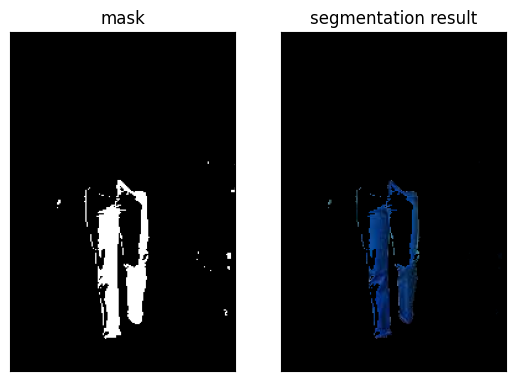

In [30]:
plt.subplot(121), plt_img(mask2, title="mask")
plt.subplot(122), plt_img(res2, title="segmentation result")

(<Axes: title={'center': 'segmentation result'}>, None)

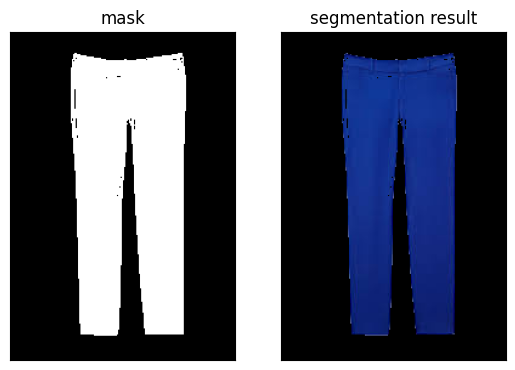

In [31]:
plt.subplot(121), plt_img(mask3, title="mask")
plt.subplot(122), plt_img(res3, title="segmentation result")

(<Axes: title={'center': 'segmentation result'}>, None)

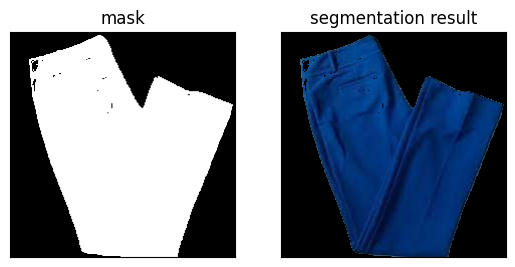

In [32]:
plt.subplot(121), plt_img(mask4, title="mask")
plt.subplot(122), plt_img(res4, title="segmentation result")

(<Axes: title={'center': 'segmentation result'}>, None)

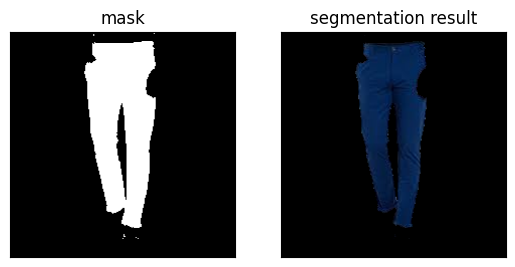

In [33]:
plt.subplot(121), plt_img(mask5, title="mask")
plt.subplot(122), plt_img(res5, title="segmentation result")

Exercise 1

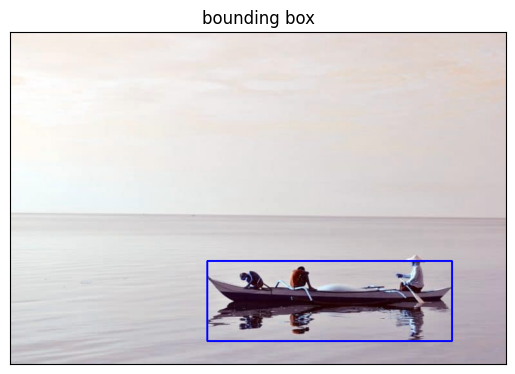

In [34]:
img = cv.imread("images/boat.jpg")
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

contours = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

img_copy = img.copy()

for contour in contours:
    # adjust threshold
    if cv.contourArea(contour) > 500:
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt_img(img_copy, "bounding box")

Exercise 2

In [6]:
img = cv.imread("images/leaf.jfif", 0)

th = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

def nothing(x):
    pass

window = "window"
cv.namedWindow(window)
cv.createTrackbar("size", window, 3, 10, nothing)
cv.createTrackbar("iter", window, 3, 10, nothing)

while (1):
    size = cv.getTrackbarPos("size", window)
    if size < 3:
        size = 3
    
    iteration = cv.getTrackbarPos("iter", window)
    if iteration < 1:
        iteration = 1
    
    kernel = np.ones((size, size), dtype=np.uint8)
    erosion = cv.erode(th, kernel, iterations=iteration)
    dilation = cv.dilate(th, kernel, iterations=iteration)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=iteration)
    closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations=iteration)

    img_combined = np.hstack((erosion, dilation, opening, closing)) 
    
    cv.imshow(window, img_combined)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

    

Exercise 3

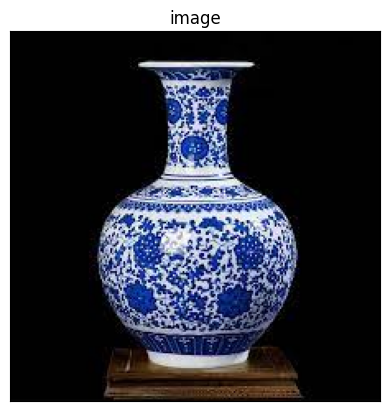

In [116]:
img = cv.imread("images/color_space/porcelain2.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img, "image")

#using 2 as reference because lesser image noises. (all black)

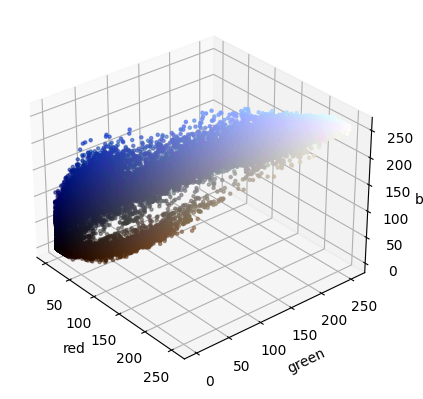

In [117]:
# split the image into seperate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatterplot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")

axis.view_init(elev=30, azim=320)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

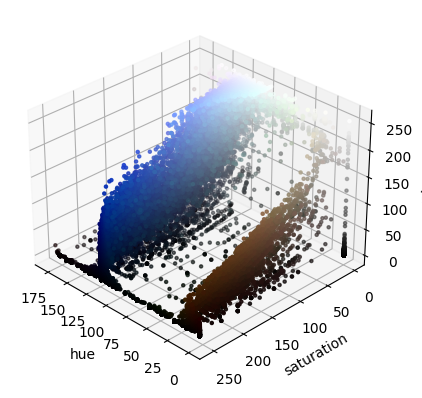

In [128]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")

axis.view_init(elev=30, azim=135)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

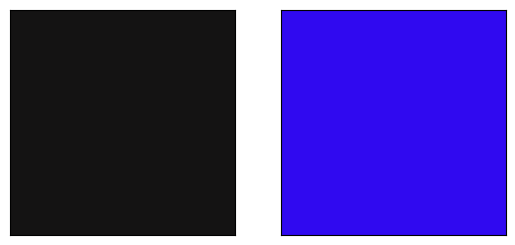

In [150]:
low = (12, 12, 20) #H, S, V
high = (125, 245, 240)

square1 = np.full((10, 10, 3), low, dtype=np.uint8)
square2 = np.full((10, 10, 3), high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

In [151]:
def colorseg(img, color_low, color_high, smooth=True):
    """Args:
    img: source image
    color_low & color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
        
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
res = [colorseg(im, low, high) for im in imgs]

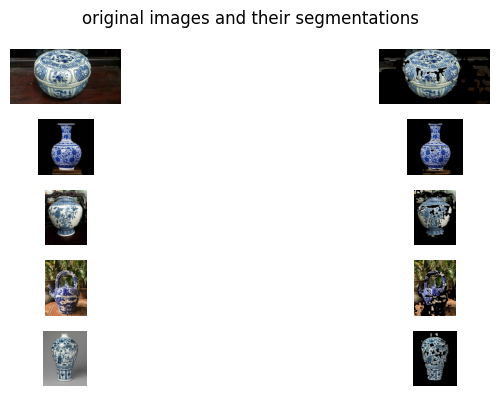

In [154]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("original images and their segmentations")
plt.tight_layout()
plt.show()